# Alzheimer's disease identification from brain x-ray images

MLUB Night - Oct 26, 2023

## Model Training

## 1. Install and import packages

In [60]:
# %%capture
!pip install sagemaker -U
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.6/915.6 KB 5.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.195.0-py2.py3-none-any.whl size=1221693 sha256=4139976dbff76e8b9a576c9ae0a01a2681af092396dd1e69b7c3aa48ea8abec5
  Stored in directory: /root/.cache/pip/wheels/4b/c5/f7/ee31f3a6c29736120026c2dfca7535c93c72edfe8e30ed205f
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.194.0
    Uninstalling sagemaker-2.194.0:
      Successfully uninstalled sagemaker-2.194.0


In [2]:
import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## 2. Setup

In [3]:
BUCKET = "mlub-dementia-demo"

In [4]:
role = sagemaker.get_execution_role()

inputs = f"s3://{BUCKET}/Alzheimer_s Dataset/"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
role

'arn:aws:iam::655329371831:role/service-role/AmazonSageMaker-ExecutionRole-20230227T103736'

## 3. Deploy and test the model

In [7]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [8]:
pytorch_model = PyTorchModel(model_data = f"s3://mlub-dementia-demo/outputs/pytorch-training-2023-10-25-19-01-28-382/output/model.tar.gz",
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py38",
                             framework_version = "1.11.0",
                             predictor_cls=ImagePredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
-------!

In [214]:
predictor.endpoint_name

'pytorch-inference-2023-10-25-20-59-40-189'

In [212]:
DATA_PATH = "/root/Intro-to-train-and-deploy-ML-model-AWS/Alzheimer_s Dataset/test/"

ModerateDemented


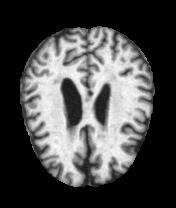

In [216]:
sub_type = random.choice(os.listdir(DATA_PATH))
sub_dir = os.path.join(ROOT, sub_type)
image_name = random.choice(os.listdir(sub_dir))
img_dir = os.path.join(sub_dir, image_name)

print(sub_type)
img_show = Image.open(img_dir)
with open(img_dir , "rb") as f:
    img = f.read()
    img_bytes = bytearray(img)
img_show

In [218]:
response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
print(np.argmax(response[0])+1)

In [217]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-10-25-20-59-40-189
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-10-25-20-59-40-189


The end of the notebook